# Importing modules

In [2]:
from pyuvdata.uvdata.mir_parser import MirParser
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as o
from scipy import signal
from lmfit.models import LinearModel, LorentzianModel
import scipy.linalg as linalg
import scipy.stats as stats 
from scipy.ndimage import generic_filter, uniform_filter1d
import pyuvdata

# Functions needed for outlier calculations

(Thank you ChatGPT)

In [3]:

def moving_median_sliding(arr, window_size, axis=1):
    """Compute moving median along a specified axis using sliding_window_view."""
    if window_size % 2 == 1:
        pad_width = window_size // 2  # For odd window size, symmetric padding
    else:
        pad_width = window_size // 2  # For even window size, pad half on both sides
    
    # Pad the array on both sides (the padding will be done symmetrically)
    padded_arr = np.pad(arr, [(0, 0) if i != axis else (pad_width, pad_width) for i in range(arr.ndim)], mode='edge')
    
    # Apply sliding window view to the padded array
    windows = np.lib.stride_tricks.sliding_window_view(padded_arr, window_shape=(window_size,), axis=axis)
    
    # Compute the median of each window
    return np.median(windows, axis=-1)

def moving_mad_sliding(arr, window_size, axis=1):
    """Compute moving Median Absolute Deviation (MAD) using sliding_window_view."""
    if window_size % 2 == 1:
        pad_width = window_size // 2  # For odd window size, symmetric padding
    else:
        pad_width = window_size // 2  # For even window size, pad half on both sides
    
    # Pad the array on both sides (the padding will be done symmetrically)
    padded_arr = np.pad(arr, [(0, 0) if i != axis else (pad_width, pad_width) for i in range(arr.ndim)], mode='edge')
    
    # Apply sliding window view to the padded array
    windows = np.lib.stride_tricks.sliding_window_view(padded_arr, window_shape=(window_size,), axis=axis)
    
    # Compute medians of each window
    medians = np.median(windows, axis=-1)
    
    # Compute MAD (Median Absolute Deviation)
    mad = np.median(np.abs(windows - medians[..., None]), axis=-1)
    return mad

# Import data

In [4]:
mir_data = MirParser("../OzoneData/211009_04:56:19", has_auto=True)

In [203]:
def stack_antenna_ac(mir_data, antenna_num, rx_num = 0, window_size = 5, flagging = True, mad_dev = 5, fill_val = np.nan, normalization = True, return_el = True):
    assert window_size % 2 != 0, "Flagging will fail if window_size is even!"
    
    #Ensure we're back to the original state
    mir_data.reset()

    #Get number of SPWs in data
    num_spws = np.unique(mir_data.sp_data['corrchunk']).size - 1 #SPW 0 is pseudocontinuum

    #Loop through each data
    for spw in range(1, num_spws + 1):
        mir_data.select(
                        where=[
                                ("sb", "eq", "u"),
                                ("corrchunk", "eq", spw),
                                ("ant", "eq", antenna_num),
                                ("antrx", "eq", rx_num),
                            ],
                            reset=True)
        
        #Load the data, parse it
        mir_data.load_data()

        #1024:-1024 cuts off first and last 1024 channels (no rechunking)
        data_stack = np.vstack([item['data'] for item in mir_data.auto_data.values()])[:, 1024:-1024]
        f_sky = (mir_data.ac_data['fsky'][0] + (np.arange(-mir_data.ac_data['nch'][0] // 2, mir_data.ac_data['nch'][0] // 2) * mir_data.ac_data['fres'][0]*1e-3))[1024:-1024]

        #Flag peaks before concatenation
        if flagging:
            med = moving_median_sliding(data_stack, window_size, 1)
            mad = moving_mad_sliding(data_stack, window_size, 1)

            out_of_bounds = np.logical_or(np.less_equal(data_stack, med - mad_dev * mad), 
                                          np.greater_equal(data_stack, med + mad_dev * mad))
            
            data_stack[out_of_bounds] = fill_val
        
        #Normalize
        if normalization:
            data_stack = data_stack/np.repeat(np.nanmean(data_stack,axis=0).reshape([1,-1]), data_stack.shape[0], axis=0)
            data_stack = data_stack/np.repeat(np.nanmean(data_stack,axis=1).reshape([-1,1]), data_stack.shape[1], axis=1)

            data_stack = data_stack/np.repeat(np.nanmean(data_stack,axis=0).reshape([1,-1]), data_stack.shape[0], axis=0)
            data_stack = data_stack/np.repeat(np.nanmean(data_stack,axis=1).reshape([-1,1]), data_stack.shape[1], axis=1)

            data_stack -= np.nanmean(data_stack)

        #Concatenate
        if spw == 1:
            stacked = 1 * data_stack
            freqs = 1 * f_sky
            spw_num = spw * np.ones(f_sky.shape)
            if return_el:
                elevation = mir_data.eng_data['actual_el']

        else:
            stacked = np.hstack((stacked, data_stack))
            freqs = np.hstack((freqs, f_sky))
            spw_num = np.hstack((spw_num, spw * np.ones(f_sky.shape)))

        #Get ready for the next one
        mir_data.reset()
    if return_el:
        return freqs, stacked, spw_num, elevation    
    return freqs, stacked, spw_num

In [204]:
freqs, stacked, spw_num, elevation = stack_antenna_ac(mir_data, 8, rx_num=1, window_size=151)

/tmp/ipykernel_132280/933735632.py:40: RuntimeWarning: Mean of empty slice
  data_stack = data_stack/np.repeat(np.nanmean(data_stack,axis=0).reshape([1,-1]), data_stack.shape[0], axis=0)
/tmp/ipykernel_132280/933735632.py:43: RuntimeWarning: Mean of empty slice
  data_stack = data_stack/np.repeat(np.nanmean(data_stack,axis=0).reshape([1,-1]), data_stack.shape[0], axis=0)


## Pretty plots showing some of the connected data

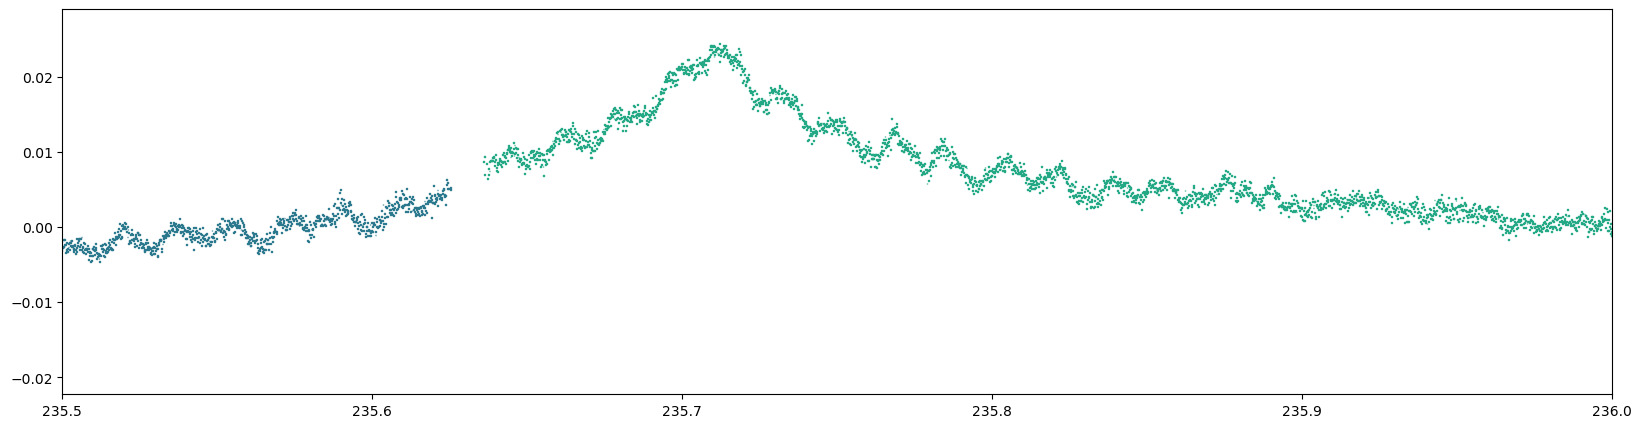

In [7]:
sort_indces = np.argsort(freqs)

plt.figure(figsize=(20, 5))
plt.scatter(freqs[sort_indces], stacked[50, sort_indces], c = spw_num[sort_indces], marker=',', s = 0.5)
#plt.scatter(freqs[spw_num == 2], stacked[150, spw_num == 2], c = spw_num[spw_num == 2], marker=',', s=0.5)
#plt.scatter(freqs[spw_num == 3], stacked[150, spw_num == 3], c = spw_num[spw_num == 3], marker=',', s=0.5)

#SPW1/2 link -- disjoint
#plt.xlim(231.5, 231.8)
#plt.ylim(0, 0.15)

#SPW 2/3 link -- overlap
#plt.xlim(233.6, 233.65)
#plt.ylim(0, 0.2)

#SPW 3/4 link -- disjoint
#plt.xlim(235.5, 235.7)
#plt.ylim(0, 0.4)

#SPW 4/5 link -- disjoint
#plt.xlim(237.5, 237.7)

#SPW 5/6 link -- disjoint
#plt.xlim(239.55, 239.7)

#plt.xlim(233.5, 238.5)
plt.xlim(235.5, 236)
plt.show()

## Concatenate SPWs 3 and 4 (O3 SPW + nearby to get full shape)

In [ ]:
spw3_freq, spw4_freq = freqs[spw_num == 3], freqs[spw_num == 4]
spw3_accs, spw4_accs = stacked[:, spw_num == 3], stacked[:, spw_num == 4]

o3_accs = np.hstack((spw3_accs[:, np.argsort(spw3_freq)], np.zeros((spw3_accs.shape[0], 71)), spw4_accs[:, np.argsort(spw4_freq)]))
o3_accs[np.isnan(o3_accs) | np.isinf(o3_accs)] = 0

#Half a channel error in here somewhere
o3_freqs = np.arange(np.nanmin(spw3_freq), np.nanmax(spw4_freq), step = np.diff(np.sort(spw3_freq))[0]) 

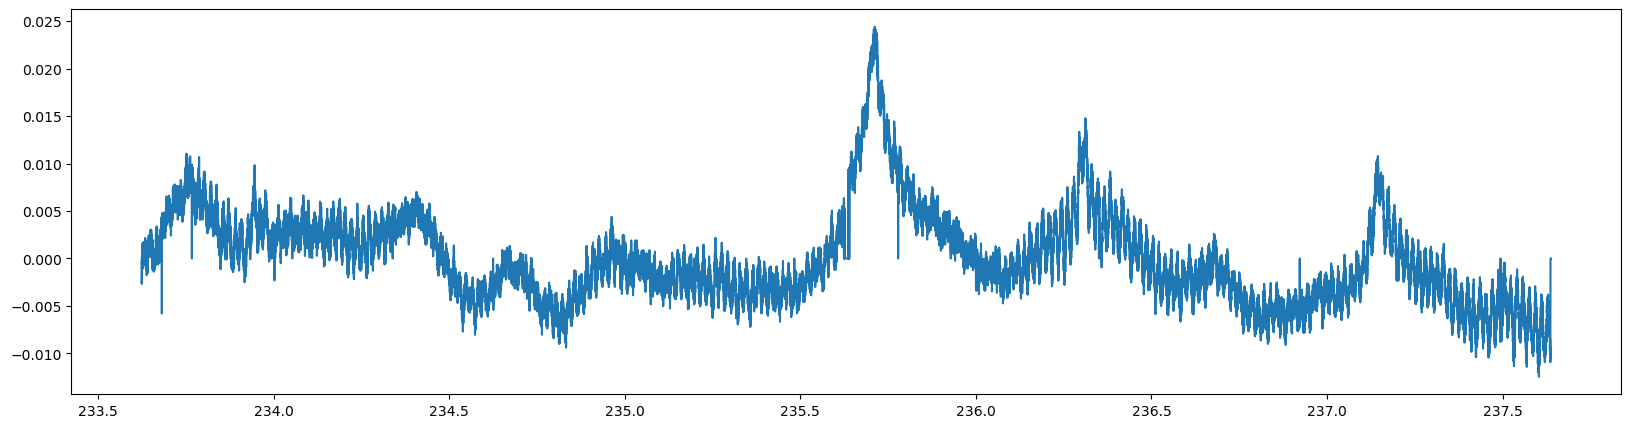

In [163]:
plt.figure(figsize=(20, 5))
plt.plot(o3_freqs, o3_accs[50, :])
#plt.plot(spw3_freq, spw3_accs)
#plt.plot(spw4_freq - np.diff(np.sort(spw3_freq))[0]/2, spw4_accs[::-1])
#plt.xlim(235.635, 235.64)

# Manual Line Masking

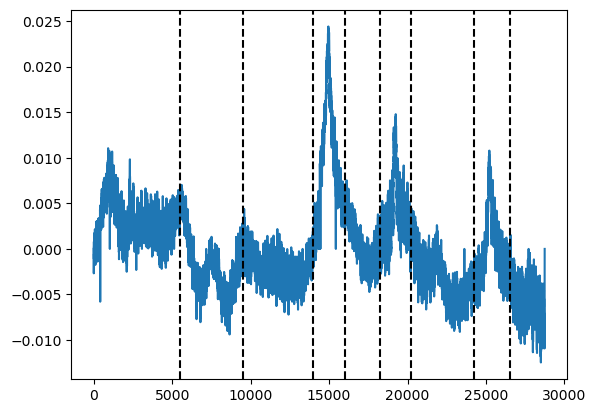

In [164]:
plt.plot(o3_accs[50, :])
plt.axvline(14000, color='k', ls = '--')
plt.axvline(16000, color='k', ls = '--')
plt.axvline(18250, color='k', ls = '--')
plt.axvline(20250, color='k', ls = '--')
plt.axvline(24250, color='k', ls = '--')
plt.axvline(26500, color='k', ls = '--')
plt.axvline(5500, color='k', ls = '--')
plt.axvline(9500, color='k', ls = '--')

In [166]:
working_spec = 1 * o3_accs
final_spec   = 1 * o3_accs

ranges = [[5500, 9500], [14000, 16000], [18250, 20250], [24250, 26500]]

baseline_indices = np.hstack([np.arange(0, 5500), np.arange(9500, 14000), np.arange(16000, 18250), np.arange(20250, 24250), np.arange(26500, o3_accs.shape[1])])

for row in range(working_spec.shape[0]):
    p = np.polyfit(baseline_indices, o3_accs[row, baseline_indices], 5)
    fit = np.poly1d(p)
    working_spec[row, baseline_indices] = o3_accs[row, baseline_indices] - fit(baseline_indices)
    working_spec[row, baseline_indices] -= np.nanmean(working_spec[row, baseline_indices])

    final_spec[row, :] = o3_accs[row, :] - fit(np.arange(o3_accs.shape[1]))
    
    #Now mask lines regions
    for range_i in ranges:
        low, high = range_i[0], range_i[1]
        working_spec[row , low : high] = 0

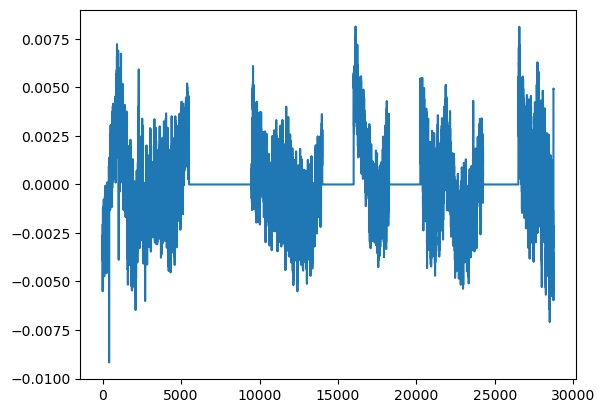

In [167]:
plt.plot(working_spec[50, :])

## Karto Cleaning, LLC (TM)

(This rhymes and sounds enough like your real name that I'd ask for royalties if you ever started a cleaning business using this name)

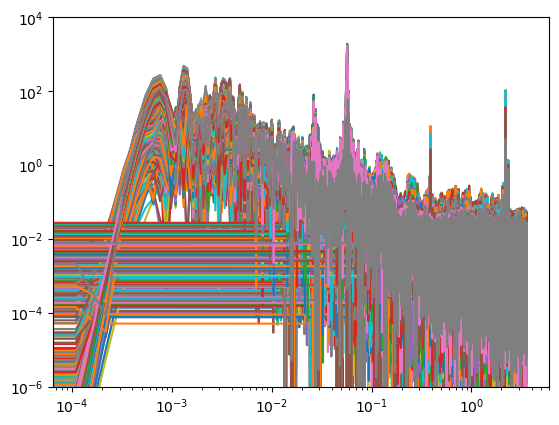

In [ ]:
#Local copy
show_plot = False
specnum = 50
data = 1 * working_spec#[:, specnum]
num_comps = 10
f0_list = [(1 / 17.8), (2 / 17.8), (3 / 17.8), (4 / 17.8), (5 / 17.8), 
           (1 / 63.1), (2 / 63.1), (3 / 63.1), (4 / 63.1), (5 / 63.1), 
           (1 / 36.6), (2 / 36.6), (3 / 36.6), (4 / 36.6), (5 / 36.6),
           (1/17.8) + (1/63.1), (2/17.8) + (2/63.1)]

polyorder_list = [5] * len(f0_list)
# polyorder_list[0] = 10
base_polyorder = 5
fft_window = (1 / 63.2) * 0.2

#Padding size -- don't do anything if the data are already a 2^n size
highest_n = int(np.ceil(np.log2(data.shape[1]))) + 1

left_pad = int(np.ceil(((2**highest_n) - data.shape[-1]) * 0.5))
right_pad = int(np.floor(((2**highest_n) - data.shape[-1]) * 0.5))
pad_slice = slice(left_pad, -right_pad)

#Stores final model and residual arrays
#model_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
#resid_fin = np.zeros((data.shape[0], 2**highest_n), dtype='complex128')
model_store = np.zeros(data.shape)
                        
#Stores *actual* FFT frequencies for model below
fftfreqs = np.fft.fftfreq(int(2**highest_n), d = 1e3 * np.abs(np.diff(o3_freqs)[0]))

freqs_pad = o3_freqs[0] + np.diff(o3_freqs)[0] * np.arange(0, 2**highest_n)

f_sky_norm = 2 * (freqs_pad - min(freqs_pad[pad_slice])) / (max(freqs_pad[pad_slice]) - min(freqs_pad[pad_slice])) - 1

for integ in range(data.shape[0]):
    #Data -- Pad integration time
    padded_integ = np.pad(data[integ, :], (left_pad, right_pad))
    fitting_mask = np.nonzero(padded_integ)
    padded_integ[fitting_mask] -= np.nanmean(padded_integ[fitting_mask])

    #Padded FFT
    padded_fft = np.fft.fft(padded_integ)
    
    #Model -- Padded model 
    model = np.zeros(padded_integ.size, dtype='complex128')
    A = np.zeros((padded_integ.size, 2 * (sum(polyorder_list) + len(f0_list)) + base_polyorder))
    for basis in range(base_polyorder):
        A[:, -(1+basis)] = f_sky_norm**basis
    
    psd = np.abs(padded_fft)**2.0    
    for idx, f0 in enumerate(f0_list):
        polyorder = polyorder_list[idx]
        model_fft = np.zeros(padded_fft.size, dtype='complex128')
        
        #Make window around |f0 * (1 + harmonic)| to search for peaks using a priori information
        selection_window = (fftfreqs >= (f0 - fft_window)) & (fftfreqs <= (f0 + fft_window))
        peak_amp = np.nanmax(psd[selection_window])
        peak_amp_position = np.where((psd == peak_amp) & selection_window)[0][0]
        #plt.plot(selection_window*1e1*(1+harmonic))
        
        #Model from FFT peak above
        model_fft[[peak_amp_position, -peak_amp_position]] = padded_fft[[peak_amp_position, -peak_amp_position]]

        model_re = np.fft.ifft(model_fft.real).real
        model_im = np.fft.ifft(1j * model_fft.imag).real

        for basis in range(polyorder + 1):
            A[:, 2 * idx * (polyorder + 1) + 2 * basis]     = model_im * f_sky_norm**basis
            A[:, 2 * idx * (polyorder + 1) + 2 * basis + 1] = model_re * f_sky_norm**basis
    
    #b is the actual data, so no need to calculate residual
    res = linalg.lstsq(A[fitting_mask, :][0], padded_integ[fitting_mask])
    polyvalues = res[0]
    model_store[integ, :] = np.matmul(A, polyvalues)[pad_slice]
    
    if show_plot:
        before = abs(np.fft.fft(padded_integ))**2.0
        plt.semilogy(fftfreqs, before)
        padded_integ[fitting_mask] -= np.matmul(A, polyvalues)[fitting_mask]
        after = abs(np.fft.fft(padded_integ))**2.0
        plt.loglog(fftfreqs, after)
        #plt.xlim([0, 275000])
        #plt.xlim(0.01, 0.2)
        plt.ylim([1e-6, 1e4])


## More plots

Text(0.5, 0, 'Freq (GHz)')

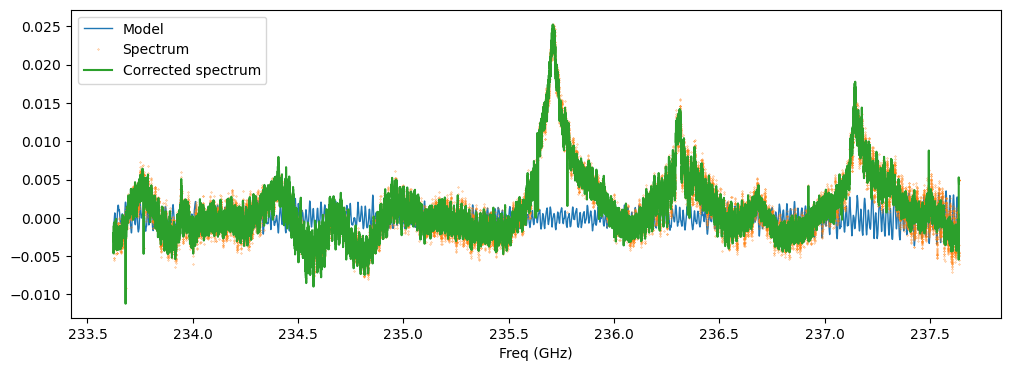

In [197]:
plot_idx = 50

plt.figure(figsize=[12,4])
#padded_integ[fitting_mask] += np.matmul(A, polyvalues)[fitting_mask]
#plt.plot(padded_integ[pad_slice])
plt.plot(o3_freqs, model_store[plot_idx], linewidth=1, label = "Model")
#padded_integ[fitting_mask] -= np.matmul(A, polyvalues)[fitting_mask]
#plt.plot(padded_integ[left_pad:-right_pad])
plt.plot(o3_freqs, final_spec[plot_idx], '.', linewidth=1, markersize=0.5, label = "Spectrum")
plt.plot(o3_freqs, final_spec[plot_idx] - model_store[plot_idx], label = "Corrected spectrum")
#plt.ylim([-0.005, 0.030])
#plt.xlim([8000, 11000])
plt.legend()
plt.xlabel('Freq (GHz)')
#plt.xlim([235.5, 235.6])


Text(0.5, 1.0, 'After subtraction')

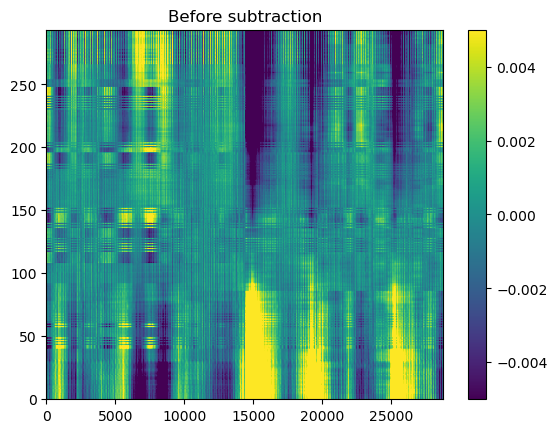

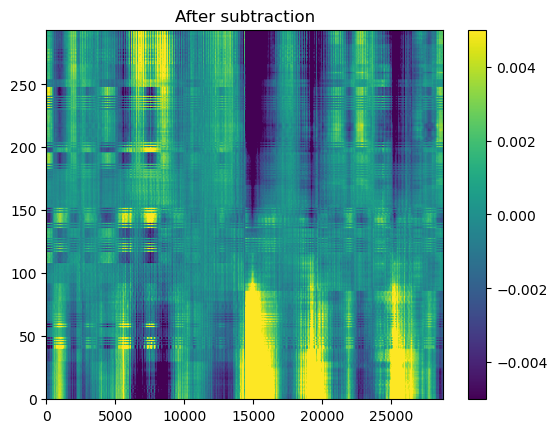

In [208]:
sort_idx = np.argsort(elevation)

plt.imshow(final_spec[sort_idx], origin='lower', aspect='auto', vmin=-0.005, vmax=0.005)
plt.colorbar()
plt.title('Before subtraction')
#plt.ylim([200, 205])
plt.figure()
plt.imshow(final_spec[sort_idx] - model_store[sort_idx], origin='lower', aspect='auto', vmin=-0.005, vmax=0.005)
plt.colorbar()
plt.title('After subtraction')
